# Fitting Quasi-Periodic Pulsations with Gaussian Processes

In [2]:
%matplotlib inline
%config IPython.matplotlib.backend = "retina"

# Importing required libraries
import celerite
from celerite import terms
import emcee
import numpy as np
import matplotlib.pyplot as plt
from pandas import rolling_median

#Making figures look nice
from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100

First, we make a damped periodic function and add random noise to simulate Kepler data:

In [3]:
def qpp_model(t,A,B,tau_g,P,phase):
    
    F = A*np.exp(-(t-B)**2/(2*tau_g**2))*np.cos(((2*np.pi)/P)*t+phase)
    
    return F

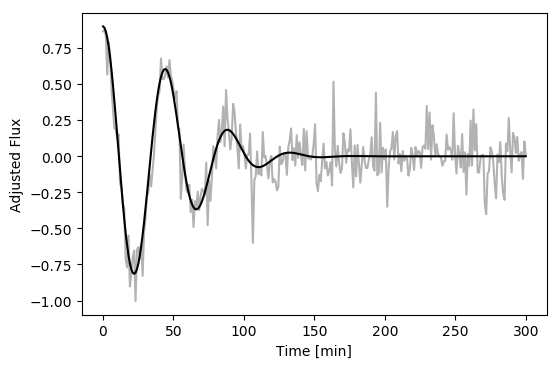

In [3]:
#QPP Model w/ random noise

t = np.linspace(0, 300, 300)
P = 45 # TRUE PERIOD

QPP = qpp_model(t,0.9,0,50,P,0)
yerr = np.random.uniform(0.05, 0.2, len(t))

y = QPP + yerr * np.random.randn(len(t))
true_y = QPP

plt.plot(t, true_y, "k", lw=1.5)
plt.plot(t, y,'k',alpha=0.3)
plt.xlabel("Time [min]")
plt.ylabel("Adjusted Flux")

plt.savefig("QPP_model.png", dpi = 300)

Now we construct a periodic GP kernel that is fed to celerite.GP and used to compute the likelihood function. For an in-depth explanation of Gaussian processes, see Foreman-Mackey et al. 2017

In [178]:
# Celerite SHO Kernel:

# A periodic component
Q = 1.0
w0 = 3.0
S0 = np.var(y) / (w0 * Q)
bounds = dict(log_S0=(-15, 15), log_Q=(-15, 15), log_omega0=(-15, 15))
kernel_1 = terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(w0),
                        bounds=bounds)
                        


In [179]:
# Custom Celerite kernel from Foreman-Mackey et al. 2017 & used in Angus et al. 2017

import autograd.numpy as np

class CustomTerm(terms.Term):
    parameter_names = ("log_a", "log_b", "log_c", "log_P")

    def get_real_coefficients(self, params):
        log_a, log_b, log_c, log_P = params
        b = np.exp(log_b)
        return (
            np.exp(log_a) * (1.0 + b) / (2.0 + b), np.exp(log_c),
        )

    def get_complex_coefficients(self, params):
        log_a, log_b, log_c, log_P = params
        b = np.exp(log_b)
        return (
            np.exp(log_a) / (2.0 + b), 0.0,
            np.exp(log_c), 2*np.pi*np.exp(-log_P),
        )

bounds = dict(log_a=(None, None), log_b=(None, 5.0), log_c=(-1.0, 1.0),
              log_P=(-0.5, 0.5))
kernel_2 = CustomTerm(log_a=0.1, log_b=0.5, log_c=-0.01, log_P=0.0,
                    bounds=bounds)
                    


In [180]:
#This cell performs all the GP calculations based on the input kernel equation
gp = celerite.GP(kernel_1, mean=np.mean(y)) # Using only periodic SHO kernel shown above
gp.compute(t, yerr) 
print("Initial log likelihood: {0}".format(gp.log_likelihood(y)))

Initial log likelihood: -78.66808554610253


In [181]:
#Optimizing likelihood function parameters:

from scipy.optimize import minimize

def neg_log_like(params, y, gp):
    gp.set_parameter_vector(params)
    return -gp.log_likelihood(y)

initial_params = gp.get_parameter_vector()
bounds = gp.get_parameter_bounds()

r = minimize(neg_log_like, initial_params, method="L-BFGS-B", bounds=bounds, args=(y, gp))
gp.set_parameter_vector(r.x)
print(r)

      fun: -177.06251642112375
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.00063665,  0.00059686,  0.00146088])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 172
      nit: 22
   status: 0
  success: True
        x: array([-3.87035106,  4.07990907, -1.96837173])


In [182]:
gp.get_parameter_dict() #Fitted parameters from SHO kernel

OrderedDict([('kernel:log_S0', -3.8703510552792593),
             ('kernel:log_Q', 4.0799090681199415),
             ('kernel:log_omega0', -1.9683717301431178)])

With these fitted SHO parameters, we can fit the noisy data and recover a period estimate:

In [183]:
x = np.linspace(0, 300, 300)
pred_mean, pred_var = gp.predict(y, x, return_var=True)
pred_std = np.sqrt(pred_var)

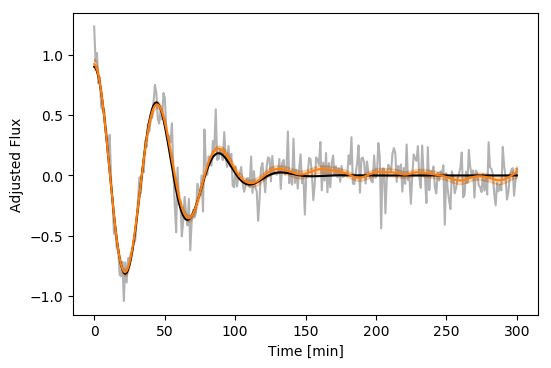

In [184]:
#Plot of model (black) + GP fit (orange)

color = "#ff7f0e"
plt.plot(t, true_y, "k", lw=1.5)
plt.plot(t, y,'k',alpha=0.3)
plt.plot(x, pred_mean, color=color)
plt.fill_between(x, pred_mean+pred_std, pred_mean-pred_std, color=color, alpha=0.3,
                 edgecolor="none")
plt.xlabel("Time [min]")
plt.ylabel("Adjusted Flux")

plt.savefig("QPP_fit.png", dpi=300)

In [185]:
#Extracting the fitted QPP period

omega = np.exp(gp.kernel.terms[0][2])
period = (2*np.pi) / omega

print("Actual Period = "+str(P)+" days")
print("Recovered Period = " + str(period) + " days")

Actual Period = 45 days
Recovered Period = 44.9813876554 days


## Distribution of 100 QPP periods recovered by GP

The next section explores runs the GP routine 100 times and explores the distribution of recovered periods

In [186]:
#This loops over the GP fitting process and builds an array of recovered periods

p_arr = np.zeros(100)

for i in range(0,100):

    t = np.linspace(0, 300, 300)
    P = 45 # TRUE PERIOD

    QPP = qpp_model(t,0.9,0,50,P,0)
    yerr = np.random.uniform(0.05, 0.1, len(t))

    y = QPP + yerr * np.random.randn(len(t))
    true_y = QPP

    Q = 1.0
    w0 = 3.0
    S0 = np.var(y) / (w0 * Q)
    bounds = dict(log_S0=(-15, 15), log_Q=(-15, 15), log_omega0=(-15, 15))
    kernel_1 = terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(w0), bounds=bounds)

    gp = celerite.GP(kernel_1, mean=np.mean(y))
    gp.compute(t, yerr) 

    from scipy.optimize import minimize

    def neg_log_like(params, y, gp):
        gp.set_parameter_vector(params)
        return -gp.log_likelihood(y)

    initial_params = gp.get_parameter_vector()
    bounds = gp.get_parameter_bounds()

    r = minimize(neg_log_like, initial_params, method="L-BFGS-B", bounds=bounds, args=(y, gp))
    gp.set_parameter_vector(r.x)

    omega = np.exp(gp.kernel.terms[0][2])
    period = (2*np.pi) / omega

    p_arr[i] = period

Mean: 44.4153746246
STD: 0.322487187445


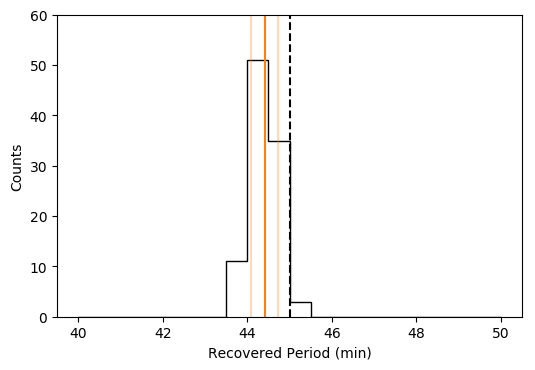

In [187]:
# Distribution of recovered periods

plt.hist(p_arr, range=(P-5,P+5), bins = 20, histtype = "step", color="k")
p_mean = np.mean(p_arr)
p_sig = np.std(p_arr)
print("Mean: " +str(p_mean))
print("STD: " +str(p_sig))
plt.plot([P,P],[0,100],"k--")
plt.plot([p_mean,p_mean],[0,100],color=color)
plt.plot([p_mean-p_sig,p_mean-p_sig],[0,100],color=color,alpha=0.3)
plt.plot([p_mean+p_sig,p_mean+p_sig],[0,100],color=color,alpha=0.3)
plt.ylim(0,60)
plt.xlabel("Recovered Period (min)")
plt.ylabel("Counts")
plt.savefig("p_hist.png", dpi=300)
# Orange = mean & standard deviation
# Dashed black = true period

## Exploring the period - $\tau$ parameter space: 

In [188]:
p_grid = np.zeros((10,10))
sig_grid = np.zeros((10,10))
p_arr = np.zeros(21)

for k in range(10):   
    
    for j in range(10):
        
        for i in range(len(p_arr)):
            
            t = np.linspace(0, 300, 300)
            P = (k+2)*5 # TRUE PERIOD
            tau = (j+2)*5 # TRUE DECAY TIME


            QPP = qpp_model(t,0.9,0,tau,P,0)
            yerr = np.random.uniform(0.05, 0.1, len(t))

            y = QPP + yerr * np.random.randn(len(t))
            true_y = QPP
            
            Q = 1.0
            w0 = 3.0
            S0 = np.var(y) / (w0 * Q)
            bounds = dict(log_S0=(-15, 15), log_Q=(-15, 15), log_omega0=(-15, 15))
            kernel_1 = terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(w0), bounds=bounds)

            gp = celerite.GP(kernel_1, mean=np.mean(y))
            gp.compute(t, yerr) 

            from scipy.optimize import minimize

            def neg_log_like(params, y, gp):
                gp.set_parameter_vector(params)
                return -gp.log_likelihood(y)

            initial_params = gp.get_parameter_vector()
            bounds = gp.get_parameter_bounds()

            r = minimize(neg_log_like, initial_params, method="L-BFGS-B", bounds=bounds, args=(y, gp))
            gp.set_parameter_vector(r.x)

            omega = np.exp(gp.kernel.terms[0][2])
            period = (2*np.pi) / omega
    
            p_arr[i] = period
        
        p_range = np.where((p_arr > P-5) & (p_arr < P+5))
        #print(np.std(p_arr[p_range]))
        p_grid[k][j] = (P - np.median(p_arr[p_range])) / P
        sig_grid[k][j] = np.std(p_arr[p_range]) / P
              
    #print("Recovered: "+str(np.mean(p_arr))+", True: "+str(P)+", Tau = "+str(tau))
    print("Loop: "+str(k+1)+" , P = "+str(P))

Loop: 1 , P = 10
Loop: 2 , P = 15
Loop: 3 , P = 20
Loop: 4 , P = 25
Loop: 5 , P = 30
Loop: 6 , P = 35
Loop: 7 , P = 40
Loop: 8 , P = 45
Loop: 9 , P = 50
Loop: 10 , P = 55


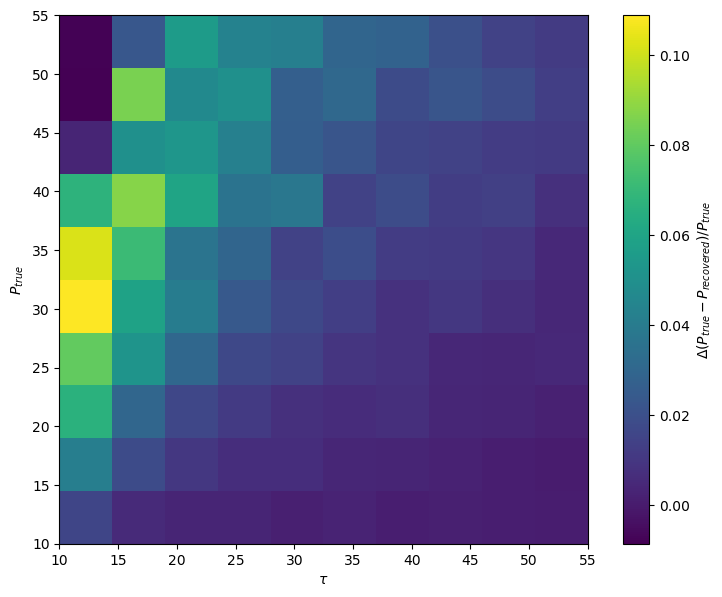

In [189]:
plt.figure(figsize = (9,7))

plt.imshow(p_grid, origin = "lower", extent = (10,55,10,55), cmap = "viridis")
plt.xlabel(r"$\tau$")
plt.ylabel("$P_{true}$")
plt.colorbar(label = r"$\Delta (P_{true} - P_{recovered}) / P_{true}$")

plt.savefig("period_grid.png", dpi = 300)

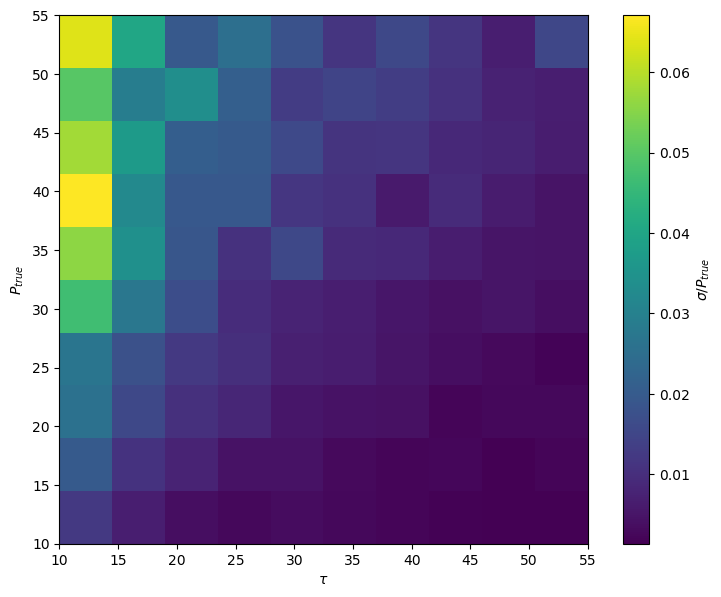

In [190]:
plt.figure(figsize = (9,7))

plt.imshow(sig_grid, origin = "lower", extent = (10,55,10,55), cmap = "viridis")
plt.xlabel(r"$\tau$")
plt.ylabel("$P_{true}$")
plt.colorbar(label = r"$\sigma / P_{true}$")

plt.savefig("error_grid.png", dpi = 300)

## Fitting ACTUAL Flares


Now we'll test the efficacy of this GP rountine on actual flare data from the Kepler Input Catalog:

In [4]:
from astropy.io import fits

In [5]:
qpp_flare = fits.open("QPP-LC.fits.txt")

In [6]:
cols = qpp_flare[1].columns
cols

ColDefs(
    name = 'TIME'; format = 'D'; unit = 'BJD - 2454833'; disp = 'D14.7'
    name = 'TIMECORR'; format = 'E'; unit = 'd'; disp = 'E13.6'
    name = 'CADENCENO'; format = 'J'; disp = 'I10'
    name = 'SAP_FLUX'; format = 'E'; unit = 'e-/s'; disp = 'E14.7'
    name = 'SAP_FLUX_ERR'; format = 'E'; unit = 'e-/s'; disp = 'E14.7'
    name = 'SAP_BKG'; format = 'E'; unit = 'e-/s'; disp = 'E14.7'
    name = 'SAP_BKG_ERR'; format = 'E'; unit = 'e-/s'; disp = 'E14.7'
    name = 'PDCSAP_FLUX'; format = 'E'; unit = 'e-/s'; disp = 'E14.7'
    name = 'PDCSAP_FLUX_ERR'; format = 'E'; unit = 'e-/s'; disp = 'E14.7'
    name = 'SAP_QUALITY'; format = 'J'; disp = 'B16.16'
    name = 'PSF_CENTR1'; format = 'D'; unit = 'pixel'; disp = 'F10.5'
    name = 'PSF_CENTR1_ERR'; format = 'E'; unit = 'pixel'; disp = 'E14.7'
    name = 'PSF_CENTR2'; format = 'D'; unit = 'pixel'; disp = 'F10.5'
    name = 'PSF_CENTR2_ERR'; format = 'E'; unit = 'pixel'; disp = 'E14.7'
    name = 'MOM_CENTR1'; format = 'D'; uni

Of course, we'll need to isolate a good-looking flare in the light curve:

In [7]:
qpp_data = qpp_flare[1].data

In [8]:
qpp_time = qpp_data["TIME"]
mjd_time = qpp_time + 2454833 - 2400000.5
qpp_flux = qpp_data["SAP_FLUX"]
qpp_flux_err = qpp_data["SAP_FLUX_ERR"]
qpp_rel_flux = (qpp_flux - np.nanmedian(qpp_flux)) / np.nanmedian(qpp_flux)


(-70, 300)

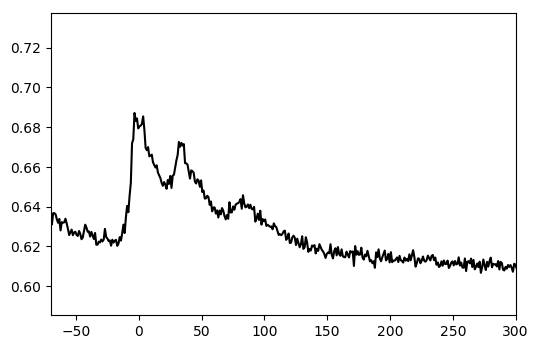

In [9]:
t_start = 55287.422
plt.plot((mjd_time - t_start)*24*60,qpp_flux / 1e4,"k")
plt.xlim(-70,300)

/Users/Riley/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: pd.rolling_median is deprecated for ndarrays and will be removed in a future version
  


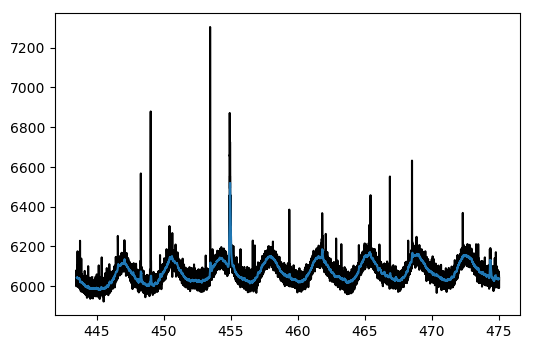

In [10]:
plt.plot(qpp_time,qpp_flux,"k-")
plt.plot(qpp_time,rolling_median(qpp_flux,100,center=True))

Now that we've isolated the flare, we need to subtract the underlying exponential decay so we can fit just the pulsation:

In [11]:
def decay(t,A,t0,B,C):
    
    return A*np.exp(-t/t0) + (B*t) + C

(0.5, 0.7)

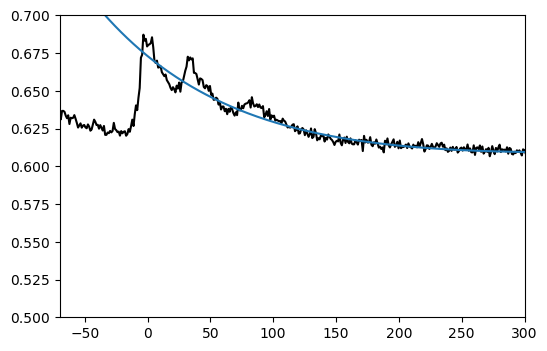

In [12]:
plt.plot((mjd_time - t_start)*24*60,qpp_flux / 1e4,"k-")
plt.plot((mjd_time - t_start)*24*60,decay((mjd_time - t_start)*24*60,0.08,111.846,3.66e-5,0.54) + 0.053)
plt.xlim(-70,300)
plt.ylim(.5,.7)

In [13]:
ymodel = decay((mjd_time - t_start)*24*60,0.08,111.846,3.66e-5,0.54) + 0.053

ok = np.where(((mjd_time - t_start)*24*60 > 250) &
              ((mjd_time - t_start)*24*60 < 300))
ynew = ((qpp_flux / np.median(qpp_flux[ok]) * np.median(ymodel[ok])) - ymodel)

In [14]:
tnew = (mjd_time - t_start)*24*60
yerr = qpp_flux_err / 1e4

Here's the decay-subtracted flare data with a damped periodic function layed over top. Function parameters are those from Pugh et. al. 2012's least-squares fit of this flare.

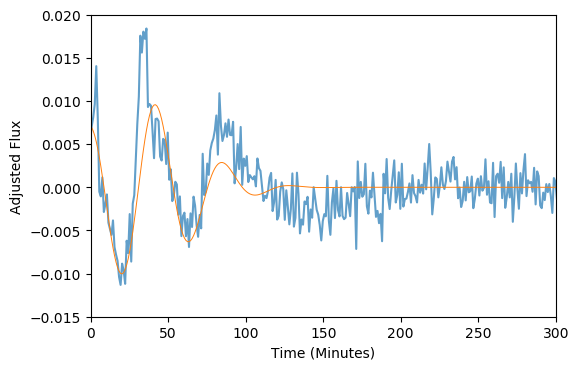

In [15]:
plt.plot(tnew, ynew, alpha=0.7)
plt.plot(tnew, qpp_model((mjd_time - t_start)*24*60,.0103,28,36,44.6,0.37), lw=.7)
plt.xlim(0,300);
plt.ylim(-.015, .02);
plt.xlabel('Time (Minutes)')
plt.ylabel('Adjusted Flux')

In [16]:
flare = np.where((tnew > 0) & (tnew < 300))
shortflare = np.where((tnew > 0) & (tnew < 300))

tnew_f = tnew[flare]
ynew_f = ynew[flare]
yerr_f = yerr[flare]
tnew_sf = tnew[shortflare]
ynew_sf = ynew[shortflare]
yerr_sf = yerr[shortflare]

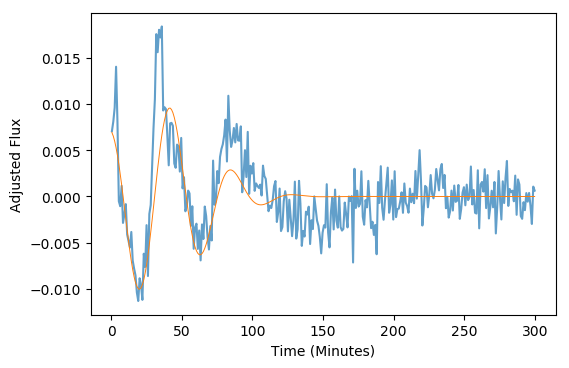

In [17]:
plt.plot(tnew_f, ynew_f, alpha=0.7)
plt.plot(tnew_sf, qpp_model(tnew_sf,.0103,28,36,44.6,0.37), lw=.7)

plt.xlabel('Time (Minutes)')
plt.ylabel('Adjusted Flux')

Obviously not a great fit...

Let's run the GP routine on the flare data!

In [18]:
#Celerite SHO Kernel:

Q = 1.0
w0 = 3.0
S0 = np.var(ynew_sf) / (w0 * Q)
bounds = dict(log_S0=(-15, 15), log_Q=(-15, 15), log_omega0=(-15, 15))
kernel = terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(w0),
                        bounds=bounds)

In [19]:
#This cell performs all the GP calculations based on the input kernel equation
gp = celerite.GP(kernel, mean=np.mean(ynew_sf)) 
gp.compute(tnew_sf, yerr_sf) 
print("Initial log likelihood: {0}".format(gp.log_likelihood(ynew_sf)))

Initial log likelihood: 1198.8436033607368


In [20]:
#Optimizing likelihood function parameters:

from scipy.optimize import minimize

def neg_log_like(params, ynew_sf, gp):
    gp.set_parameter_vector(params)
    return -gp.log_likelihood(ynew_sf)

initial_params = gp.get_parameter_vector()
bounds = gp.get_parameter_bounds()

r = minimize(neg_log_like, initial_params, method="L-BFGS-B", bounds=bounds, args=(ynew_sf, gp))
gp.set_parameter_vector(r.x)
print(r)

      fun: -1391.7446205576762
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([  4.54747351e-05,   6.82121026e-04,   6.82121026e-04])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 144
      nit: 23
   status: 0
  success: True
        x: array([-9.48793962,  0.11278696, -1.66312069])


In [21]:
gp.get_parameter_dict() #Fitted parameters from SHO kernel

OrderedDict([('kernel:log_S0', -9.4879396172465444),
             ('kernel:log_Q', 0.1127869626793153),
             ('kernel:log_omega0', -1.6631206887890455)])

In [22]:
x = tnew_sf
pred_mean, pred_var = gp.predict(ynew_sf, x, return_var=True)
pred_std = np.sqrt(pred_var)

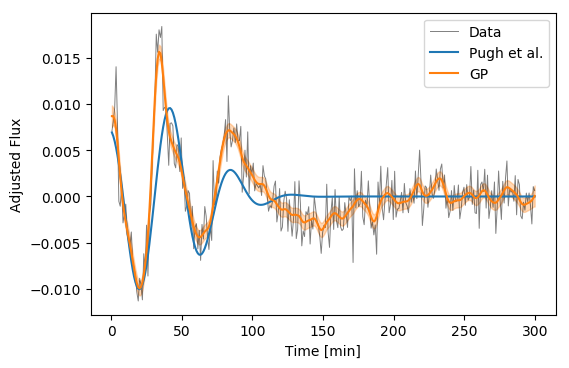

In [23]:
color = "#ff7f0e"
plt.plot(tnew_f, ynew_f, "k", lw=0.7, alpha = 0.5, label="Data") # Flare data
plt.plot(tnew_sf, qpp_model(tnew_sf,.0103,28,36,44.6,0.37),label="Pugh et al.") # Least-squares fit from Pugh et al 2012
plt.plot(x, pred_mean, color=color,label="GP") # GP fit
plt.fill_between(x, pred_mean+pred_std, pred_mean-pred_std, color=color, alpha=0.3,
                 edgecolor="none") # Standard deviation boundaries
plt.xlabel("Time [min]")
plt.ylabel("Adjusted Flux")
plt.legend()


plt.savefig("Fit_comparison(full).png", dpi=300, bbox_inches='tight', pad_inches=0.25)

This fit looks a lot better! Although might be overfitting the tail end...

In [24]:
omega_0 = np.exp(gp.kernel.terms[0][2])
period = (2*np.pi) / omega_0

print("Recovered Period = " + str(period) + " minutes")

Recovered Period = 33.148509562 minutes


In [25]:
S_0 = np.exp(gp.kernel.terms[0][0])
Q_0 = np.exp(gp.kernel.terms[0][1])
print(S_0)
print(Q_0)

7.57600372618e-05
1.11939343497


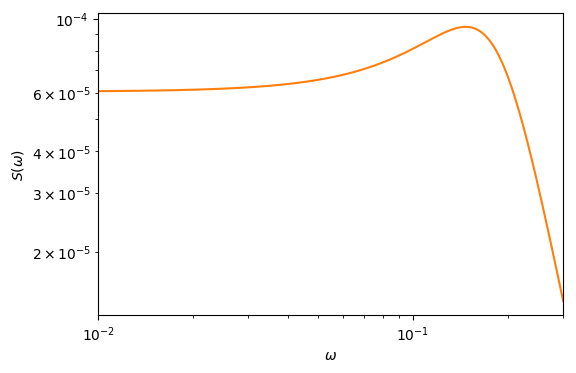

In [26]:
# Maximum likelihood power spectrum:

omega = np.exp(np.linspace(np.log(0.01), np.log(0.3), 5000))
psd = gp.kernel.get_psd(omega)

plt.plot(omega, psd, color=color)


plt.yscale("log")
plt.xscale("log")
plt.xlim(omega[0], omega[-1])
plt.xlabel("$\omega$")
plt.ylabel("$S(\omega)$");

## EMCEE Modeling

GP parameter estimation can be improved by integrating a Markov Chain Monte Carlo (MCMC) process into the GP routine.

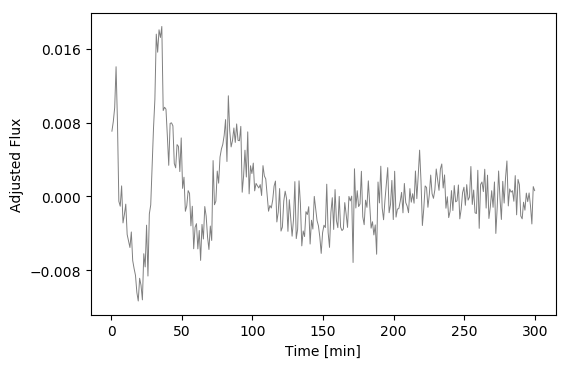

In [27]:
from celerite.modeling import Model

# Define the model
class MeanModel(Model):
    parameter_names = ("A", "B", "tau", "P", "phase")

    def get_value(self, t):
        
        return self.A*np.exp(-(t-self.B)**2 / (2*self.tau**2))*np.cos(((2*np.pi*t) / self.P) + self.phase) 
    
    def compute_gradient(self, t):
        
        alpha = np.exp(-(t-self.B)**2 / (2*self.tau**2))*np.cos(((2*np.pi*t) / self.P) + self.phase)
        dA = alpha
        dB = (self.A*(t-self.B)*alpha) / self.tau**2
        dtau = (self.A*(t-self.B)*alpha) / self.tau**3
        dP = (2*np.pi*self.A*t*np.exp(-(t-self.B)**2 / (2*self.tau**2))*np.sin(((2*np.pi*t) / self.P) + self.phase)) / self.P**2
        dphase = -self.A*np.exp(-(t-self.B)**2 / (2*self.tau**2))*np.sin(((2*np.pi*t) / self.P) + self.phase)
        
        return np.array([dA, dB, dtau, dP, dphase])

mean_model = MeanModel(A = 0.0103, B = 28, tau = 36, P = 44.6, phase = 0.37)
true_params = mean_model.get_parameter_vector()

# Plot the data
plt.plot(tnew_f, ynew_f, "k", lw = 0.7, alpha = 0.5)
plt.ylabel("Adjusted Flux")
plt.xlabel("Time [min]")
plt.gca().yaxis.set_major_locator(plt.MaxNLocator(5))

In [99]:
#Celerite SHO Kernel:

Q = 1.0
w0 = 3.0
S0 = np.var(ynew_f) / (w0 * Q)
bounds = dict(log_S0=(-15, 15), log_Q=(-15, 15), log_omega0=(-15, 15))
kernel = terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(w0),
                        bounds=bounds)

gp = celerite.GP(kernel, mean=np.mean(ynew_f))
gp.compute(tnew_f, yerr_f)
print("Initial log-likelihood: {0}".format(gp.log_likelihood(ynew_f)))

# Define a cost function
def neg_log_like(params, ynew_f, gp):
    gp.set_parameter_vector(params)
    return -gp.log_likelihood(ynew_f)

def grad_neg_log_like(params, ynew_f, gp):
    gp.set_parameter_vector(params)
    return -gp.grad_log_likelihood(ynew_f)[1]

def log_like(params):
    gp.set_parameter_vector(params)
    return gp.log_likelihood(ynew_f)

def log_probability(params):
    gp.set_parameter_vector(params)
    lp = gp.log_prior()
    if not np.isfinite(lp):
        return -np.inf
    return gp.log_likelihood(ynew_f) + lp

Initial log-likelihood: 1198.8436033607368


In [100]:
# Fit for the maximum likelihood parameters

initial = np.array([gp.kernel.terms[0][0],gp.kernel.terms[0][1],gp.kernel.terms[0][2]]) # Non-optimized SHOTerm params 
ndim, nwalkers = len(initial), 8
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_like)

print("Running burn-in...")
p0 = initial + 1e-8 * np.random.randn(nwalkers, ndim)
p0, lp, _ = sampler.run_mcmc(p0, 500)

print("Running production...")
sampler.reset()
sampler.run_mcmc(p0, 2000);

Running burn-in...
Running production...


In [101]:
initial

array([-11.94022649,   0.        ,   1.09861229])

In [102]:
samples = sampler.flatchain

mcmc1, mcmc2, mcmc3 = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                             zip(*np.percentile(samples, [16, 50, 84],
                                                axis=0)))
initial_params = np.array([mcmc1, mcmc2, mcmc3])

print(initial_params)

[[-9.35958739  0.52623676  0.46687154]
 [ 0.0682726   0.42778023  0.4264741 ]
 [-1.67424693  0.14337886  0.13126148]]


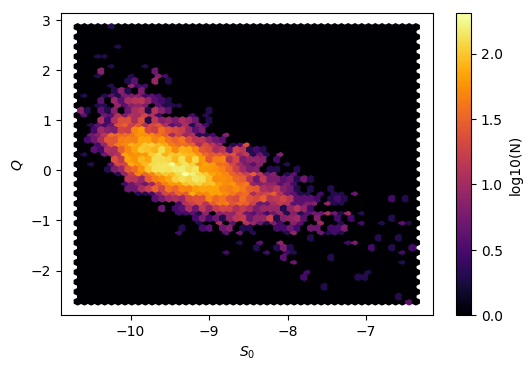

In [103]:
plt.hexbin(samples[:,0],samples[:,1],gridsize=50,bins='log',cmap='inferno')
plt.colorbar(label='log10(N)')
plt.xlabel(r'$S_0$')
plt.ylabel(r'$Q$')

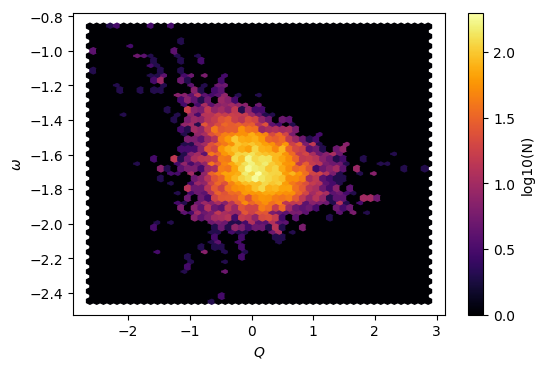

In [104]:
plt.hexbin(samples[:,1],samples[:,2],gridsize=50,bins='log',cmap='inferno')
plt.colorbar(label='log10(N)')
plt.xlabel(r'$Q$')
plt.ylabel(r'$\omega$')

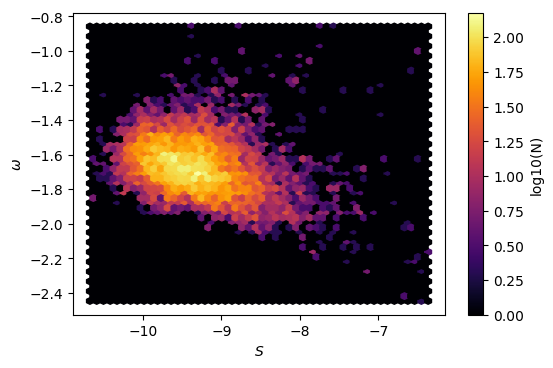

In [105]:
plt.hexbin(samples[:,0],samples[:,2],gridsize=50,bins='log',cmap='inferno')
plt.colorbar(label='log10(N)')
plt.xlabel(r'$S$')
plt.ylabel(r'$\omega$')

In [106]:
true_params = initial

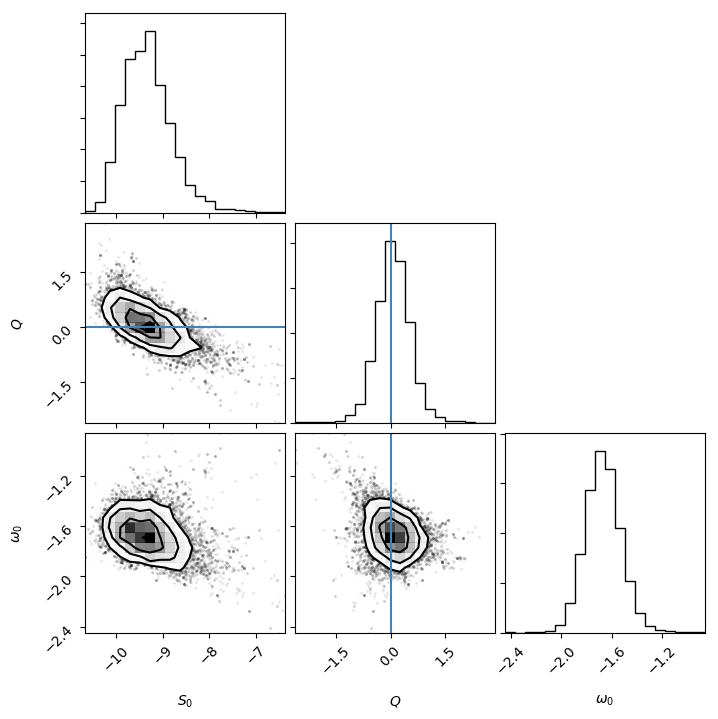

In [107]:
import corner
corner.corner(samples[:, (0,1,2)], truths=true_params,
              labels=[r"$S_0$", r"$Q$", r"$\omega_0$"]);

In [108]:
bounds = gp.get_parameter_bounds()

r = minimize(neg_log_like, initial_params[:,0], method="L-BFGS-B", bounds=bounds, args=(ynew_f, gp))
gp.set_parameter_vector(r.x)
print(r)

      fun: -1391.744620574776
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([  4.54747351e-05,   1.81898940e-04,   1.36424205e-04])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 52
      nit: 11
   status: 0
  success: True
        x: array([-9.48789012,  0.11274775, -1.66312364])


In [109]:
print(r.x)

[-9.48789012  0.11274775 -1.66312364]


In [110]:
initial = r.x
ndim, nwalkers = len(initial), 8
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_like)

print("Running burn-in...")
p0 = initial + 1e-8 * np.random.randn(nwalkers, ndim)
p0, lp, _ = sampler.run_mcmc(p0, 500)

print("Running production...")
sampler.reset()
sampler.run_mcmc(p0, 2000);

Running burn-in...
Running production...


In [111]:
samples = sampler.flatchain

mcmc1f, mcmc2f, mcmc3f = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                             zip(*np.percentile(samples, [16, 50, 84],
                                                axis=0)))
final_params = np.array([mcmc1, mcmc2, mcmc3])
print(final_params)

[[-9.35958739  0.52623676  0.46687154]
 [ 0.0682726   0.42778023  0.4264741 ]
 [-1.67424693  0.14337886  0.13126148]]


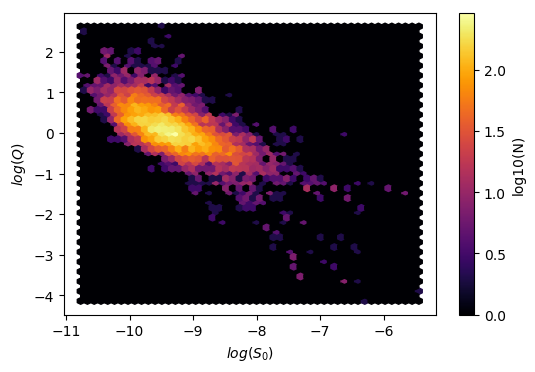

In [136]:
plt.hexbin(samples[:,0],samples[:,1],gridsize=50,bins='log',cmap='inferno')
plt.colorbar(label='log10(N)')
plt.xlabel(r'$log(S_0)$')
plt.ylabel(r'$log(Q)$')

plt.savefig('S-Q_hexbin.pdf', dpi=300)

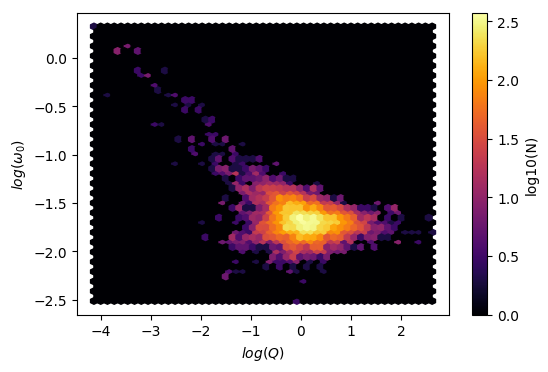

In [137]:
plt.hexbin(samples[:,1],samples[:,2],gridsize=50,bins='log',cmap='inferno')
plt.colorbar(label='log10(N)')
plt.xlabel(r'$log(Q)$')
plt.ylabel(r'$log(\omega_0)$')

plt.savefig('Q-omega_hexbin.pdf', dpi=300)

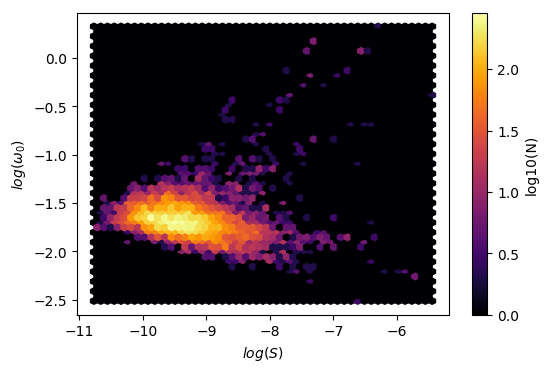

In [138]:
plt.hexbin(samples[:,0],samples[:,2],gridsize=50,bins='log',cmap='inferno')
plt.colorbar(label='log10(N)')
plt.xlabel(r'$log(S)$')
plt.ylabel(r'$log(\omega_0)$')

plt.savefig('S-omega_hexbin.pdf', dpi=300)

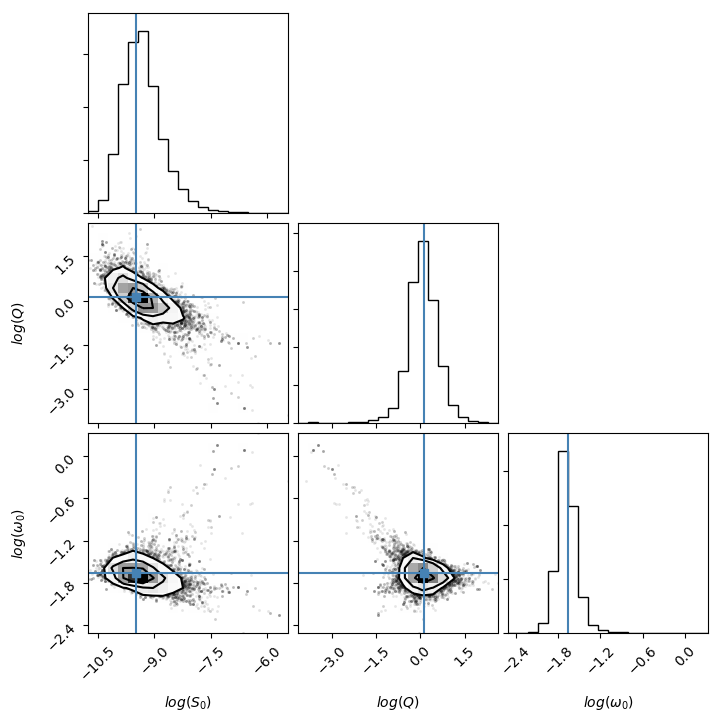

In [135]:
import corner
corner.corner(samples[:, (0,1,2)], truths=r.x,
              labels=[r"$log(S_0)$", r"$log(Q)$", r"$log(\omega_0)$"]);

plt.savefig('corner.pdf', dpi=300)

In [133]:
print(final_params)

[[-9.35958739  0.52623676  0.46687154]
 [ 0.0682726   0.42778023  0.4264741 ]
 [-1.67424693  0.14337886  0.13126148]]


In [139]:
2*np.pi / (np.exp(final_params[2,:]))

array([ 33.51938719,   5.44391357,   5.51028083])

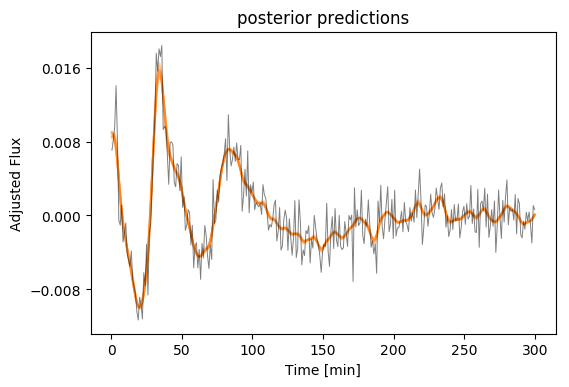

In [142]:
for s in samples[np.random.randint(len(samples), size=24)]:
    gp.set_parameter_vector(s)
    mu = gp.predict(ynew_f, tnew_f, return_cov=False)
    plt.plot(tnew_sf, mu, color=color, alpha=0.1)

plt.plot(tnew_f, ynew_f, "k", lw = 0.7, alpha = 0.5)
plt.ylabel("Adjusted Flux")
plt.xlabel("Time [min]")
plt.gca().yaxis.set_major_locator(plt.MaxNLocator(5))
plt.title("posterior predictions");